This notebook demonstrates how to load and evaluate  the probabilistic Quantile Gradient Boosting (QGB) Vertical Total Electron Content (VTEC) models, which provide 95% confidence intervals. QGB VTEC models forecast VTEC 1-day ahead for grid points at 10° of longitude, and 10°, 40°, and 70° of latitude. They were developed within the study "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M., submitted to the Space Weather Jornal, AGU. 

Quantiles were estimated by multiplying the quantile values β by the positive and negative residuals in the loss function to obtain the quantile loss (QL) (see Equation 7 in the paper). 
Quantile values of $\beta=\left \{0.025, 0.975 \right \}$ are chosen for estimating the lower and upper confidence bounds, respectively, to obtain a confidence interval of $95\%$. The mean quantile $\beta=\left \{0.50 \right \}$ provides the median VTEC. 

It has been shown that the quantile loss can model the data uncertainty. The Gradient Boosted tree is fast, performs well on structured input data, even on relatively small datasets, and has proven to be a powerful method in many data science competitions. For more information on Gradient Boosting for VTEC, see Natras, R.; Soja, B.; Schmidt, M. Ensemble Machine Learning of Random Forest, AdaBoost and XGBoost for Vertical Total Electron Content Forecasting. Remote Sens. 2022, 14, 3547. https://doi.org/10.3390/rs14153547.

The notebook was created by Randa Natras: randa.natras@hotmail.com; randa.natras@tum.de

**Installation**

In [1]:
#Installation of the version of Scikit-learn used for the training of the models
!pip install scikit-learn==1.0.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


### **Libraries**

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

## Loading the test dataset

The dataset from the paper "Uncertainty Quantification for Machine Learning-based Ionosphere and Space Weather Forecasting" by Natras R., Soja B. and Schmidt M.

In [4]:
data_test_df= pd.read_csv ('Test_data_VTEC.csv', delimiter=';')

In [ ]:
data_test_df.head()

,Year,DOY,Hour,R (Sunspots),F10.7 index,SW Plasma Speed,Bz (GSM),Dst index,Kp index,AE index,VTEC_10N,VTEC_40N,VTEC_70N,VTEC_10N (t+24),VTEC_40N (t+24),VTEC_70N (t+24)
0,2017,1,0,12,70.1,552,-2.5,-12,33,132,5.9,7.6,2.1,7.0,7.1,2.3
1,2017,1,1,12,70.1,556,-3.5,-13,33,329,5.4,7.2,2.4,6.7,6.6,1.6
2,2017,1,2,12,70.1,552,-3.0,-16,33,336,5.2,6.8,2.5,5.6,6.9,1.1
3,2017,1,3,12,70.1,539,-0.1,-23,37,357,5.0,8.2,2.8,4.7,7.8,0.8
4,2017,1,4,12,70.1,543,-2.8,-29,37,439,4.3,8.0,3.5,3.5,7.3,0.9


In [153]:
#In the next lines, a date-time column is created and set as the index column.
data_test_df['Date-time'] = (pd.to_datetime(data_test_df['Year'] * 1000 + data_test_df['DOY'], format='%Y%j') + pd.to_timedelta(data_test_df['Hour '], unit='h'))
data_test_df_2 = data_test_df.set_index('Date-time')

In [ ]:
data_test_df_2.head()

,Year,DOY,Hour,R (Sunspots),F10.7 index,SW Plasma Speed,Bz (GSM),Dst index,Kp index,AE index,VTEC_10N,VTEC_40N,VTEC_70N,VTEC_10N (t+24),VTEC_40N (t+24),VTEC_70N (t+24)
Date-time,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,2017,1,0,12,70.1,552,-2.5,-12,33,132,5.9,7.6,2.1,7.0,7.1,2.3
2017-01-01 01:00:00,2017,1,1,12,70.1,556,-3.5,-13,33,329,5.4,7.2,2.4,6.7,6.6,1.6
2017-01-01 02:00:00,2017,1,2,12,70.1,552,-3.0,-16,33,336,5.2,6.8,2.5,5.6,6.9,1.1
2017-01-01 03:00:00,2017,1,3,12,70.1,539,-0.1,-23,37,357,5.0,8.2,2.8,4.7,7.8,0.8
2017-01-01 04:00:00,2017,1,4,12,70.1,543,-2.8,-29,37,439,4.3,8.0,3.5,3.5,7.3,0.9


### Prepare input features

In [160]:
#Calculation of the exponential moving average over the last 30 days and 4 days
def compute_exponential_moving_average (data_frame, input_col, new_col_EMA_30d, new_col_EMA_96h):
  ema_30d = data_frame[input_col].ewm(span=(30*24), adjust=False).mean()
  ema_96h = data_frame[input_col].ewm(span=(4*24), adjust=False).mean()
  data_frame[new_col_EMA_30d] = ema_30d
  data_frame[new_col_EMA_96h] = ema_96h

In [169]:
#Calculation of the first and second VTEC derivatives
def compute_derivatives (data_frame, input_col, new_col_der1, new_col_der2):
  der1 = data_frame[input_col].diff()
  der2 = data_frame[input_col].diff().diff()
  data_frame[new_col_der1] = der1
  data_frame[new_col_der2] = der2

In [168]:
compute_exponential_moving_average (data_test_df_2, 'VTEC_10N', 'VTEC_10N_EMA(30d)', 'VTEC_10N_EMA(96h)')
compute_exponential_moving_average (data_test_df_2, 'VTEC_40N', 'VTEC_40N_EMA(30d)', 'VTEC_40N_EMA(96h)')
compute_exponential_moving_average (data_test_df_2, 'VTEC_70N', 'VTEC_70N_EMA(30d)', 'VTEC_70N_EMA(96h)')

In [171]:
compute_derivatives (data_test_df_2, 'VTEC_10N', 'VTEC_10N_der1', 'VTEC_10N_der2')
compute_derivatives (data_test_df_2, 'VTEC_40N', 'VTEC_40N_der1', 'VTEC_40N_der2')
compute_derivatives (data_test_df_2, 'VTEC_70N', 'VTEC_70N_der1', 'VTEC_70N_der2')

In [172]:
#Calculation of the new features leads to NaN values, which are now omitted
data_test_df_2.dropna(inplace = True)

Learning algorithms based on decision trees do not require data normalization because they are not sensitive to the scale of input features. So the data were not standardized.

No sin/cos encoding is performed for features Day of year and Hour of day, because the decision tree does not use Euclidean distances, but works differently. It splits the dataset from one region into two non-overlapping sub-regions based on a single splitting variable and the split point (for more details, see https://www.mdpi.com/2072-4292/14/15/3547). Therefore, decision trees do not benefit from sin/cos encoding.

Preparation of the data for testing the model: extraction of the X and Y variables.

In [174]:
X_10_test_df=data_test_df_2.drop (['Year','VTEC_40N', 'VTEC_70N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)', 'VTEC_40N_EMA(30d)', 'VTEC_70N_EMA(30d)', 'VTEC_40N_EMA(96h)', 'VTEC_70N_EMA(96h)',  'VTEC_40N_der1', 'VTEC_70N_der1', 'VTEC_40N_der2', 'VTEC_70N_der2' ], axis=1)
X_40_test_df=data_test_df_2.drop (['Year','VTEC_10N', 'VTEC_70N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)' , 'VTEC_10N_EMA(30d)', 'VTEC_70N_EMA(30d)', 'VTEC_10N_EMA(96h)', 'VTEC_70N_EMA(96h)', 'VTEC_10N_der1', 'VTEC_70N_der1', 'VTEC_10N_der2', 'VTEC_70N_der2'], axis=1)
X_70_test_df=data_test_df_2.drop (['Year','VTEC_10N', 'VTEC_40N', 'VTEC_10N (t+24)', 'VTEC_40N (t+24)','VTEC_70N (t+24)' , 'VTEC_40N_EMA(30d)', 'VTEC_10N_EMA(30d)', 'VTEC_40N_EMA(96h)', 'VTEC_10N_EMA(96h)', 'VTEC_40N_der1', 'VTEC_10N_der1', 'VTEC_40N_der2', 'VTEC_10N_der2'], axis=1)

In [175]:
X_10_test_df.head()

,DOY,Hour,R (Sunspots),F10.7 index,SW Plasma Speed,Bz (GSM),Dst index,Kp index,AE index,VTEC_10N,VTEC_10N_EMA(30d),VTEC_10N_EMA(96h),VTEC_10N_der1,VTEC_10N_der2
Date-time,,,,,,,,,,,,,,
2017-01-01 02:00:00,1,2,12,70.1,552,-3.0,-16,33,336,5.2,5.896675,5.875470,-0.2,0.3
2017-01-01 03:00:00,1,3,12,70.1,539,-0.1,-23,37,357,5.0,5.894188,5.857419,-0.2,0.0
2017-01-01 04:00:00,1,4,12,70.1,543,-2.8,-29,37,439,4.3,5.889766,5.825308,-0.7,-0.5
2017-01-01 05:00:00,1,5,12,70.1,542,-4.0,-30,37,400,3.7,5.883691,5.781487,-0.6,0.1
2017-01-01 06:00:00,1,6,12,70.1,527,-1.3,-28,27,305,7.1,5.887065,5.808673,3.4,4.0


In [192]:
X_10_test = X_10_test_df.to_numpy()
X_40_test = X_40_test_df.to_numpy()
X_70_test = X_70_test_df.to_numpy()

In [193]:
y_10_test = data_test_df_2 ['VTEC_10N (t+24)'].to_numpy()
y_40_test = data_test_df_2 ['VTEC_40N (t+24)'].to_numpy()
y_70_test = data_test_df_2 ['VTEC_70N (t+24)'].to_numpy()

# **Quantile Gradient Boosting (QGB) VTEC Models**

## **Loading the models**

Separate models were trained for each value of $\beta= \{0.025, 0.50 0.975 \}$ so that for each grid point at 10° of longitude, and 10°, 40°, and 70° of latitude,  the three models were developed to estimate the upper bound (UB), median VTEC (med) and lower bound (UB) with a confidence interval of $95\%$.


In [184]:
qgb_UB_10E70N = joblib.load('qgb_10E70N_VTEC_upper_1d.sav')
qgb_med_10E70N = joblib.load('qgb_10E70N_VTEC_median_1d.sav')
qgb_LB_10E70N = joblib.load('qgb_10E70N_VTEC_lower_1d.sav')

In [181]:
qgb_UB_10E40N = joblib.load('qgb_10E40N_VTEC_upper_1d.sav')
qgb_med_10E40N = joblib.load('qgb_10E40N_VTEC_median_1d.sav')
qgb_LB_10E40N = joblib.load('qgb_10E40N_VTEC_lower_1d.sav')

In [183]:
qgb_UB_10E10N = joblib.load('qgb_10E10N_VTEC_upper_1d.sav')
qgb_med_10E10N = joblib.load('qgb_10E10N_VTEC_median_1d.sav')
qgb_LB_10E10N = joblib.load('qgb_10E10N_VTEC_lower_1d.sav')

In [194]:
y_10E70N_upper = qgb_UB_10E70N.predict(X_70_test)
y_10E70N_median = qgb_med_10E70N.predict(X_70_test)
y_10E70N_lower = qgb_LB_10E70N.predict(X_70_test)

In [241]:
y_10E40N_upper = qgb_UB_10E40N.predict(X_40_test)
y_10E40N_median = qgb_med_10E40N.predict(X_40_test)
y_10E40N_lower = qgb_LB_10E40N.predict(X_40_test)

In [196]:
y_10E10N_upper = qgb_UB_10E10N.predict(X_10_test)
y_10E10N_median = qgb_med_10E10N.predict(X_10_test)
y_10E10N_lower = qgb_LB_10E10N.predict(X_10_test)

## **Test data, statistics**

In [206]:
#Calculation of statistics: RMS, Corr. and Confidence Intervals (CI)
def compute_statistics (y_test, y_pred_median, y_pred_upper, y_pred_lower):
  print('RMS (median):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_median)),2))
  print('Corr. (median):',  scipy.stats.pearsonr(y_test, y_pred_median)[0])
  print('CI (upper):', round((y_pred_upper-y_pred_median).mean(axis=0), 2))
  print('CI (lower):', round((y_pred_median-y_pred_lower).mean(axis=0), 2))
  print('CI (average):', round((((y_pred_upper-y_pred_median)+(y_pred_median-y_pred_lower)).mean(axis=0))/2, 2))

In [207]:
print('10E 70N (year 2017)' )
compute_statistics (y_70_test, y_10E70N_median, y_10E70N_upper, y_10E70N_lower)
print('---------' )
print('10E 40N (year 2017)' )
compute_statistics (y_40_test, y_10E40N_median, y_10E40N_upper, y_10E40N_lower)
print('---------' )
print('10E 10N (year 2017)' )
compute_statistics (y_10_test, y_10E10N_median, y_10E10N_upper, y_10E10N_lower)

10E 70N (year 2017)
RMS (median): 1.05
Corr. (median): 0.9124626570484939
CI (upper): 2.22
CI (lower): 2.36
CI (average): 2.29
---------
10E 40N (year 2017)
RMS (median): 1.89
Corr. (median): 0.8896282843588483
CI (upper): 3.61
CI (lower): 3.29
CI (average): 3.45
---------
10E 10N (year 2017)
RMS (median): 2.22
Corr. (median): 0.9764987842675888
CI (upper): 5.75
CI (lower): 5.32
CI (average): 5.53


In [201]:
print('10E 70N (Apr 25-29, 2017)' )
compute_statistics (y_70_test[2712:2832], y_10E70N_median[2712:2832], y_10E70N_upper[2712:2832], y_10E70N_lower[2712:2832])
print('---------' )
print('10E 40N (Apr 25-29, 2017)' )
compute_statistics (y_40_test[2712:2832], y_10E40N_median[2712:2832], y_10E40N_upper[2712:2832], y_10E40N_lower[2712:2832])
print('---------' )
print('10E 10N (Apr 25-29, 2017)' )
compute_statistics (y_10_test[2712:2832], y_10E10N_median[2712:2832], y_10E10N_upper[2712:2832], y_10E10N_lower[2712:2832])

10E 70N (Apr 25-29, 2017)
RMS (median): 0.77
Corr. (median): 0.8825108712943789
CI (upper): 2.41
CI (lower): 2.66
CI (average): 2.54
---------
10E 40N (Apr 25-29, 2017)
RMS (median): 1.27
Corr. (median): 0.9589917055687306
CI (upper): 3.64
CI (lower): 3.58
CI (average): 3.61
---------
10E 10N (Apr 25-29, 2017)
RMS (median): 2.09
Corr. (median): 0.9877266417959445
CI (upper): 4.91
CI (lower): 5.45
CI (average): 5.18


In [219]:
print('10E 70N (Sep 6-10, 2017)' )
compute_statistics (y_70_test[5927:6047], y_10E70N_median[5927:6047], y_10E70N_upper[5927:6047], y_10E70N_lower[5927:6047])
print('---------' )
print('10E 40N (Sep 6-10, 2017)' )
compute_statistics (y_40_test[5927:6047], y_10E40N_median[5927:6047], y_10E40N_upper[5927:6047], y_10E40N_lower[5927:6047])
print('---------' )
print('10E 10N (Sep 6-10, 2017)' )
compute_statistics (y_10_test[5927:6047], y_10E10N_median[5927:6047], y_10E10N_upper[5927:6047], y_10E10N_lower[5927:6047])

10E 70N (Sep 6-10, 2017)
RMS (median): 1.73
Corr. (median): 0.7063186759912075
CI (upper): 5.16
CI (lower): 2.81
CI (average): 3.99
---------
10E 40N (Sep 6-10, 2017)
RMS (median): 3.35
Corr. (median): 0.7997985937815839
CI (upper): 4.97
CI (lower): 4.21
CI (average): 4.59
---------
10E 10N (Sep 6-10, 2017)
RMS (median): 3.98
Corr. (median): 0.9544108614035974
CI (upper): 6.4
CI (lower): 6.62
CI (average): 6.51


## **Percentage of actual values within confidence intervals (CI)**

In [216]:
#Calculation of percentage of ground truth (GT) within CI
def compute_percentage_in_CI (y_test, y_pred_upper, y_pred_lower):
  diff_up = y_pred_upper - y_test
  diff_low = y_pred_lower - y_test
  
  in_values=0; out_values=0
  
  for i in range(diff_up.size):
    if np.any((diff_up[i] >= 0) & (diff_low[i] <= 0)):
      in_values = in_values + 1
    else:
      out_values = out_values + 1
        
  whole = in_values + out_values
  
  percent_in_CI = in_values/whole * 100
  percent_out_CI = out_values/whole * 100

  print('GT  within the CI (%):', round(percent_in_CI,2))
  print('GT outside the CI (%):', round(percent_out_CI,2))

In [217]:
print('10E 70N (2017)' )
compute_percentage_in_CI (y_70_test, y_10E70N_upper, y_10E70N_lower)
print('---------' )
print('10E 40N (2017)' )
compute_percentage_in_CI (y_40_test, y_10E40N_upper, y_10E40N_lower)
print('---------' )
print('10E 10N (2017)' )
compute_percentage_in_CI (y_10_test, y_10E10N_upper, y_10E10N_lower)

10E 70N (2017)
GT  within the CI (%): 95.4
GT outside the CI (%): 4.6
---------
10E 40N (2017)
GT  within the CI (%): 93.43
GT outside the CI (%): 6.57
---------
10E 10N (2017)
GT  within the CI (%): 96.21
GT outside the CI (%): 3.79


In [220]:
print('10E 70N (Apr 25-29, 2017)' )
compute_percentage_in_CI (y_70_test[2712:2832], y_10E70N_upper[2712:2832], y_10E70N_lower[2712:2832])
print('---------' )
print('10E 40N (Apr 25-29, 2017)' )
compute_percentage_in_CI (y_40_test[2712:2832], y_10E40N_upper[2712:2832], y_10E40N_lower[2712:2832])
print('---------' )
print('10E 10N (Apr 25-29, 2017)' )
compute_percentage_in_CI (y_10_test[2712:2832], y_10E10N_upper[2712:2832], y_10E10N_lower[2712:2832])

10E 70N (Apr 25-29, 2017)
GT  within the CI (%): 100.0
GT outside the CI (%): 0.0
---------
10E 40N (Apr 25-29, 2017)
GT  within the CI (%): 100.0
GT outside the CI (%): 0.0
---------
10E 10N (Apr 25-29, 2017)
GT  within the CI (%): 95.83
GT outside the CI (%): 4.17


In [221]:
print('10E 70N (Sep 6-10, 2017)' )
compute_percentage_in_CI (y_70_test[5927:6047], y_10E70N_upper[5927:6047], y_10E70N_lower[5927:6047])
print('---------' )
print('10E 40N (Sep 6-10, 2017)' )
compute_percentage_in_CI (y_40_test[5927:6047], y_10E40N_upper[5927:6047], y_10E40N_lower[5927:6047])
print('---------' )
print('10E 10N (Sep 6-10, 2017)' )
compute_percentage_in_CI (y_10_test[5927:6047], y_10E10N_upper[5927:6047], y_10E10N_lower[5927:6047])

10E 70N (Sep 6-10, 2017)
GT  within the CI (%): 94.17
GT outside the CI (%): 5.83
---------
10E 40N (Sep 6-10, 2017)
GT  within the CI (%): 82.5
GT outside the CI (%): 17.5
---------
10E 10N (Sep 6-10, 2017)
GT  within the CI (%): 89.17
GT outside the CI (%): 10.83


## **Plots**

In [ ]:
base = datetime.datetime(2017, 9, 6)
dates2 = np.array([base + datetime.timedelta(hours=(1 * j))
                  for j in range(120)])

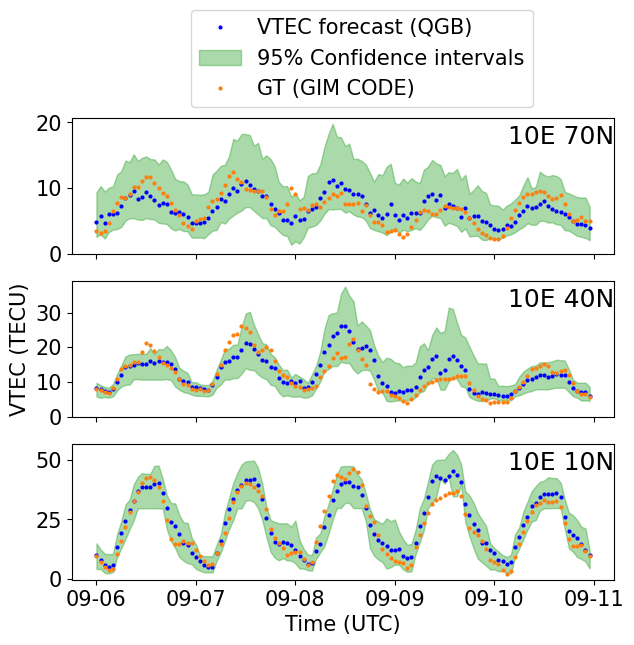

In [ ]:
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates2, y_10E70N_median[5927:6047], 'bo',linewidth=0,markersize=2,  label='VTEC forecast (QGB)')
axs[0].fill_between(dates2, y_10E70N_lower[5927:6047], y_10E70N_upper[5927:6047],  alpha=0.4, color='tab:green',  label='95% Confidence intervals')
axs[0].plot(dates2, y_70_test_new[5927:6047],  'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(0.0, 21.0, 10.0)))

axs[1].plot(dates2, y_10E40N_median[5927:6047], 'bo',linewidth=0,markersize=2,  label='VTEC forecast (QGB)')
axs[1].fill_between(dates2, y_10E40N_lower[5927:6047], y_10E40N_upper[5927:6047],  alpha=0.4, color='tab:green',  label='95% Confidence intervals')
axs[1].plot(dates2, y_40_test_new[5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(0.0, 31.0, 10.0)))

axs[2].plot(dates2, y_10E10N_median[5927:6047], 'bo',linewidth=0,markersize=2,  label='VTEC forecast (QGB)')
axs[2].fill_between(dates2, y_10E10N_lower[5927:6047], y_10E10N_upper[5927:6047],  alpha=0.4, color='tab:green',  label='95% Confidence intervals')
axs[2].plot(dates2, y_10_test_new[5927:6047],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(0.0, 51.0, 25.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.2, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()
plt.rcParams.update({'font.size': 15})

In [ ]:
base = datetime.datetime(2017, 4, 25)
dates3 = np.array([base + datetime.timedelta(hours=(1 * j))
                  for j in range(120)])

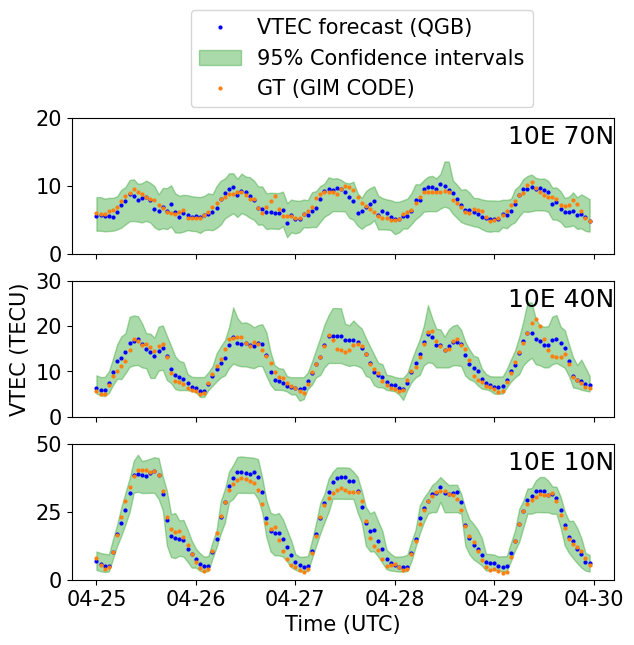

In [ ]:
fig, axs = plt.subplots(3, sharex=True)

axs[0].plot(dates3, y_10E70N_median[2712:2832], 'bo',linewidth=0,markersize=2,  label='VTEC forecast (QGB)')
axs[0].fill_between(dates3, y_10E70N_lower[2712:2832], y_10E70N_upper[2712:2832],  alpha=0.4, color='tab:green',  label='95% Confidence intervals')
axs[0].plot(dates3, y_70_test_new[2712:2832],  'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[0].set_title('10E 70N', y=0.75, loc='right')
axs[0].set_yticks((np.arange(0.0, 21.0, 10.0)))

axs[1].plot(dates3, y_10E40N_median[2712:2832], 'bo',linewidth=0,markersize=2,  label='VTEC forecast (QGB)')
axs[1].fill_between(dates3, y_10E40N_lower[2712:2832], y_10E40N_upper[2712:2832],  alpha=0.4, color='tab:green',  label='95% Confidence intervals')
axs[1].plot(dates3, y_40_test_new[2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[1].set_title('10E 40N', y=0.75, loc='right')
axs[1].set(ylabel='VTEC (TECU)')
axs[1].set_yticks((np.arange(0.0, 31.0, 10.0)))

axs[2].plot(dates3, y_10E10N_median[2712:2832], 'bo',linewidth=0,markersize=2,  label='VTEC forecast (QGB)')
axs[2].fill_between(dates3, y_10E10N_lower[2712:2832], y_10E10N_upper[2712:2832],  alpha=0.4, color='tab:green',  label='95% Confidence intervals')
axs[2].plot(dates3, y_10_test_new[2712:2832],   'o',color='tab:orange', linewidth=1,markersize=2, label='GT (GIM CODE)')
axs[2].set_title('10E 10N', y=0.75, loc='right')
axs[2].set_yticks((np.arange(0.0, 51.0, 25.0)))
axs[2].set(xlabel='Time (UTC)')

axs[0].legend(loc="best", bbox_to_anchor=(0.2, 1, 0, 0))
date_form = DateFormatter("%m-%d")
axs[2].xaxis.set_major_formatter(date_form)

plt.rcParams ['figure.figsize'] = [7.0, 6.0]
plt.show()
plt.rcParams.update({'font.size': 15})

## **Feature importance**

In [242]:
features_70 = X_70_test_df.columns[:]
features_40 = X_40_test_df.columns[:]
features_10 = X_10_test_df.columns[:]

In [225]:
#Feature importance plot
def feature_importance_plot (model, features, VTEC_point):

  importance = model.feature_importances_

  plt.barh([x for x in range(len(importance))], importance, color='#8f63f4', align='center')
  plt.title(VTEC_point)
  plt.yticks(range(len(features)), features)
  plt.xticks((np.arange(0.0, 1.1, 0.2)))
  plt.xlabel('Relative Importance')

  plt.rcParams ['figure.figsize'] = [3.6, 5]
  plt.rcParams.update({'font.size': 12})
  plt.show()

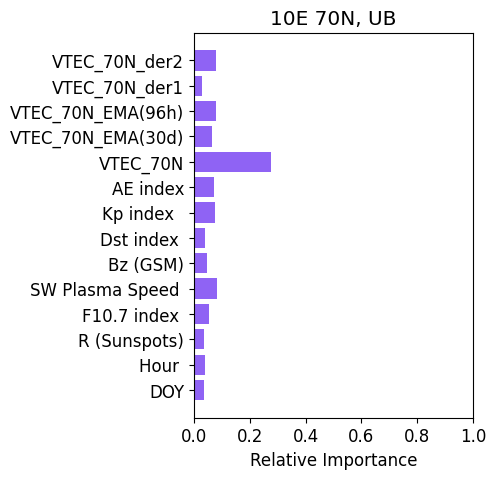

In [227]:
feature_importance_plot (qgb_UB_10E70N, features_70, '10E 70N, UB')

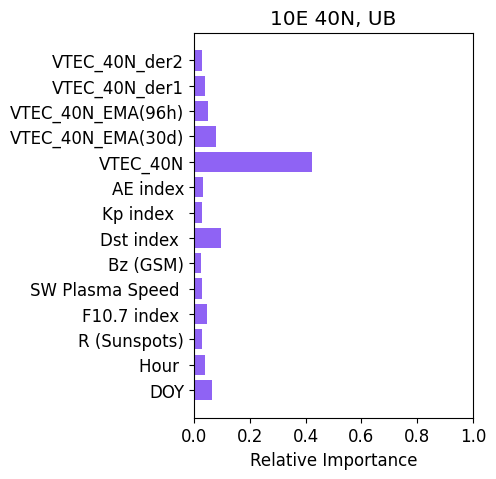

In [228]:
feature_importance_plot (qgb_UB_10E40N, features_40, '10E 40N, UB')

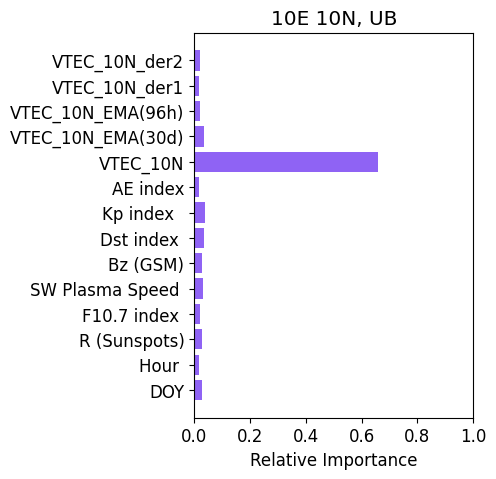

In [232]:
feature_importance_plot (qgb_UB_10E10N, features_10, '10E 10N, UB')

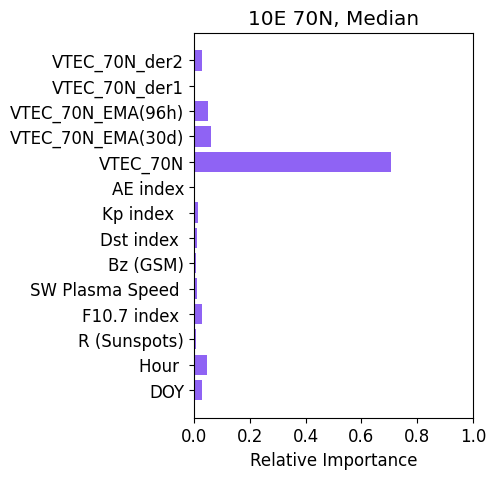

In [233]:
feature_importance_plot (qgb_med_10E70N, features_70, '10E 70N, Median')

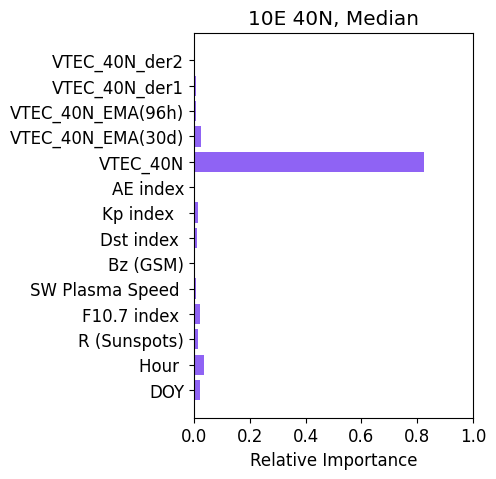

In [243]:
feature_importance_plot (qgb_med_10E40N, features_40, '10E 40N, Median')

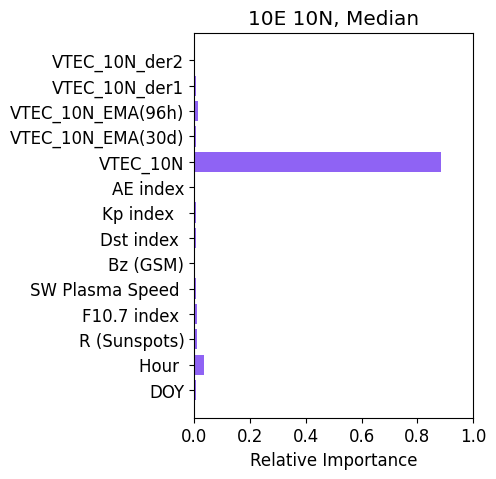

In [235]:
feature_importance_plot (qgb_med_10E10N, features_10, '10E 10N, Median')

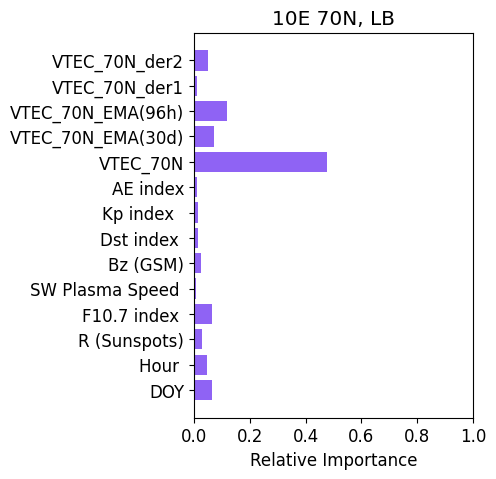

In [236]:
feature_importance_plot (qgb_LB_10E70N, features_70, '10E 70N, LB')

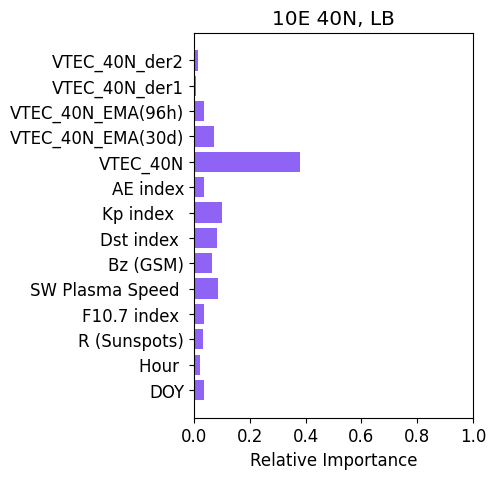

In [237]:
feature_importance_plot (qgb_LB_10E40N, features_40, '10E 40N, LB')

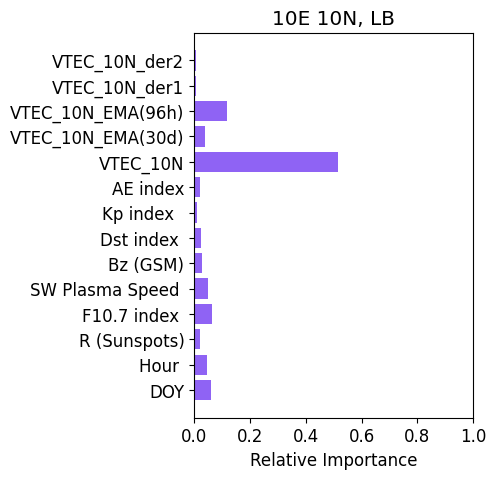

In [239]:
feature_importance_plot (qgb_LB_10E10N, features_10, '10E 10N, LB')